In [1]:
### ATOC5860 - eof_noise_reduction_cartopy
### Originally from Prof. Libby Barnes (CSU) with updates by Prof. Jennifer Kay (University of Colorado)
### Last updated September 30, 2020

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd  # library for data analysis for text files (everything but netcdf files)
import xarray  #package that open and manipulates netcdf files
import matplotlib.dates as mdates
import numpy.linalg as LA
from matplotlib.gridspec import GridSpec
import timeit
import cartopy as ct
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import importlib
import numpy.ma as ma
import numpy.linalg as LA
import matplotlib as mpl
import xarray as xr

In [2]:
def drawOnGlobe(ax, data, lats, lons, cmap='coolwarm', vmin=None, vmax=None, inc=None, cbarBool=True, contourMap=[], contourVals = [], fastBool=False, extent='both'):

    data_crs = ct.crs.PlateCarree()
    data_cyc, lons_cyc = add_cyclic_point(data, coord=lons) #fixes white line by adding point#data,lons#ct.util.add_cyclic_point(data, coord=lons) #fixes white line by adding point

    ax.set_global()
    ax.coastlines(linewidth = 1.2, color='black')
    if(fastBool):
        image = ax.pcolormesh(lons_cyc, lats, data_cyc, transform=data_crs, cmap=cmap)
    else:
        image = ax.pcolor(lons_cyc, lats, data_cyc, transform=data_crs, cmap=cmap)
    
    if(np.size(contourMap) !=0 ):
        contourMap_cyc, __ = add_cyclic_point(contourMap, coord=lons) #fixes white line by adding point
        ax.contour(lons_cyc,lats,contourMap_cyc,contourVals, transform=data_crs, colors='fuchsia')
    
    if(cbarBool):
        cb = plt.colorbar(image, shrink=.75, orientation="vertical", pad=.02, extend=extent)
        cb.ax.tick_params(labelsize=6) 
    else:
        cb = None

    image.set_clim(vmin,vmax)
    
    return cb, image

In [3]:
#### Read in the data
## 2-meter monthly air temperature anomalies from the Berkeley Earth Surface Temperature (BEST) dataset. 

ds = xr.open_dataset('BEST-1950-2018-monthlyTemp.nc') # open the data

ds = ds.sel(time = slice('1960-01-01', '2020-01-01')) # only grab certain years
ds = ds[{'latitude': slice(None, None, 4), 'longitude': slice(None, None, 4)}] # downsample to make easier to manage
ds = ds.fillna(0.) # fill Nans with 0 for a zero anomaly
print(ds)


<xarray.Dataset>
Dimensions:      (latitude: 45, longitude: 90, month_number: 12, time: 708)
Coordinates:
  * time         (time) datetime64[ns] 1960-01-31 1960-02-29 ... 2018-12-31
  * longitude    (longitude) float32 -179.5 -175.5 -171.5 ... 168.5 172.5 176.5
  * latitude     (latitude) float32 -89.5 -85.5 -81.5 -77.5 ... 78.5 82.5 86.5
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    temperature  (time, latitude, longitude) float32 -2.434859 ... 2.5780118
    climatology  (month_number, latitude, longitude) float32 -27.502026 ... -...
Attributes:
    CDI:                   Climate Data Interface version 1.9.2 (http://mpime...
    history:               Mon Mar 25 14:16:12 2019: cdo seldate,1950-01-01T0...
    institution:           Berkeley Earth Surface Temperature Project
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native For

In [4]:
# get data into a 2D matrix
X = ds['temperature'].values
X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
X.shape

### Look at the data
print(np.shape(X))
print(np.size(X,axis = 1))
print(np.min(X))
print(np.max(X))

(708, 4050)
4050
-17.501196
22.80892


In [5]:
#### Complete the EOF analysis

#spatial dimension
C = 1./np.size(X,axis = 1)*(np.dot(X,np.transpose(X)))

# calculate eigenvalues and eigenvectors of C
lam, Z = LA.eig(C)
E = np.dot(np.transpose(Z),X)

# sort eigenvalues and vector by the largest to smallest eigenvalues
i = np.flipud(np.argsort(lam))
lam = lam[i]
E = E[i,:]

# convert eigenvalues to percent variance explained
pve = 100.*lam/np.sum(lam)

print(np.shape(Z))
print(np.shape(E))

# Specify the number of EOFs that you will use to reconstruct the data
nEOF2retain=100

# reduce E and Z, retain only certain eofs
eof_number = np.arange(0,nEOF2retain)
Z = Z[:,eof_number]
E = E[eof_number,:]

print(np.shape(Z))
print(np.shape(E))

# reconstruct X
Xrecon = np.dot(Z,E)

print(np.shape(Xrecon))

(708, 708)
(708, 4050)
(708, 100)
(100, 4050)
(708, 4050)


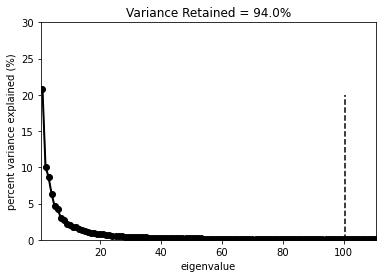

In [6]:
# plot results: EIGENVALUES
plt.plot(np.arange(1,np.size(pve)+1.),pve,'o-',linewidth = 2, color = 'black')
plt.plot([np.max(eof_number)+1.5,np.max(eof_number)+1.5],[0,20],'--k')
plt.title('Variance Retained = ' + str(np.round(np.sum(pve[eof_number]))) + '%')
plt.xlim(0.5, 110.5)
plt.ylim(0,30.)
plt.xlabel('eigenvalue')
plt.ylabel('percent variance explained (%)')

# plot error bars according to North et al.abs
# here we will assume that all of the data is independent (is that a good assumption?)
# such that Nstar = N
Nstar = np.size(X,axis = 1);
eb = pve*np.sqrt(2./Nstar);
#print(eb)
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black');

/opt/anaconda3/envs/culabenv2020/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1665: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/opt/anaconda3/envs/culabenv2020/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


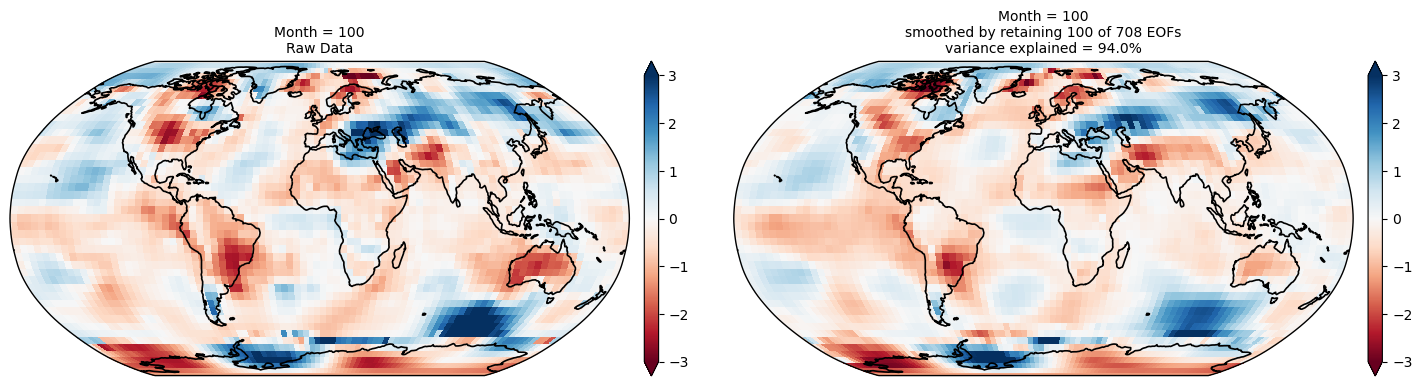

In [7]:
# plot results

month_to_plot = 100

# plotting options
maxVal = 3.
titleSize = 10
cmap = plt.cm.RdBu
fastBool = False
lats = ds['latitude']
lons = ds['longitude']
mpl.rcParams['figure.dpi'] = 100
CL = 0.
mapProj = ct.crs.Robinson(central_longitude = CL)

plt.figure(figsize=(15,4.5))

ax = plt.subplot(1,2,1,projection=mapProj)
xplot = X.reshape(X.shape[0],len(lats),len(lons))[month_to_plot,:,:]
cb, image = drawOnGlobe(ax, xplot, lats, lons, cmap=cmap, vmin = -maxVal, vmax=maxVal, cbarBool=True, fastBool=fastBool)
cb.set_label('', fontsize=titleSize)
cb.ax.tick_params(labelsize=titleSize) 
plt.title('Month = ' + str(month_to_plot) + '\nRaw Data', fontsize=titleSize)


ax = plt.subplot(1,2,2,projection=mapProj)
xplot = Xrecon.reshape(Xrecon.shape[0],len(lats),len(lons))[month_to_plot,:,:]
if(np.max(xplot.flatten())<1.):
    maxVal = np.max(xplot.flatten())
cb, image = drawOnGlobe(ax, xplot, lats, lons, cmap=cmap, vmin = -maxVal, vmax=maxVal, cbarBool=True, fastBool=fastBool)
cb.set_label('', fontsize=titleSize)
cb.ax.tick_params(labelsize=titleSize) 
plt.title('Month = ' + str(month_to_plot) + '\nsmoothed by retaining ' + str(eof_number[-1]+1) + ' of ' + str(len(pve)) + ' EOFs' +
          '\nvariance explained = ' + str(np.round(np.sum(pve[eof_number]))) + '%', fontsize=titleSize)

plt.tight_layout()